# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

## This notebook contains a simple demonstrate how can the gene embedding space could be use for predicting functional annotation.

**Install scnet using pip**

**It may be necessary to restart (not delete) the runtime after installing scENT in Google Colab. We are working on fixing this issue in future releases.**

In [ ]:
!pip install scnet

**Download example data**

In [2]:
import gdown
download_url = f'https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi'
output_path = './example.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi
From (redirected): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi&confirm=t&uuid=2d02d30a-0a49-4012-8c3b-1592b8346541
To: /content/example.h5ad
100%|██████████| 1.38G/1.38G [00:19<00:00, 69.2MB/s]


'./example.h5ad'

### Import scNET and model traning
For more details please refer to the basic tutorial notebook



In [1]:
import scNET
#We use only genes that are expressed in at least 10% of the T cell subsets.
scNET.main.EXPRESSION_CUTOFF = 0.1
scNET.main.DE_GENES_NUM = 2500


### run_scNET arguments:
 **obj (AnnData, optional):** AnnData obj.

  **pre_processing_flag (bool, optional):** If True, perform pre-processing steps.

  **human_flag (bool, optional):** Controls gene name casing in the network.

  **number_of_batches (int, optional):** Number of mini-batches for the training.

  **split_cells (bool, optional):** If True, split by cells instead of edges during training. If using A100 could be True (for 10K cells or less)

  **n_neighbors (int, optional):** Number of neighbors for building the adjacency graph.

  **max_epoch (int, optional):** Max number of epochs for model training (recommended 250-300, and for larger dataset consider also 300-350).

  **model_name (str, optional):** Identifier for saving the model outputs.
  
  **save_model_flag (bool, optional):** If True, save the trained model.

**We will use the T Cells subset to learn the gene embedding**


In [2]:
import scanpy as sc
obj = sc.read_h5ad("./example.h5ad")
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
sub_obj = obj[obj.obs["Cell Type"] == "CD8 Tcells"]
scNET.run_scNET(sub_obj, pre_processing_flag=False, human_flag=False, number_of_batches=3, split_cells=False, max_epoch=300, model_name = "Tcells")


/usr/local/lib/python3.11/dist-packages/scNET/Data/format_h_sapiens.csv
N genes: (3875, 906)


Training: 100%|██████████| 300/300 [12:55<00:00,  2.59s/it]

Best Network AUC: 0.887409676081024


**This function creates annotation table given a functional annotation dataset - default KEGG**

In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, random_split
import copy
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import gseapy as gp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
SEED = 12
def create_annotation(node_features, embedded_genes, threshold=50, annotation_set=gp.get_library("KEGG_2021_Human")):

    #KEGG_custom = gp.get_library("GO_Biological_Process_2023")
    node_features.index = node_features.index.str.upper()
    all_genes = node_features.index
    filtered = {pathway: [gene for gene in genes if gene in all_genes]
                  for pathway, genes in annotation_set.items()}
    array = [ (gene, key) for key in filtered for gene in filtered[key] ]
    kegg_df = pd.DataFrame(array)
    annot = pd.DataFrame(0, index=all_genes, columns=filtered.keys())

    for key, values in filtered.items():
        for value in values:
            annot.loc[value, key] = 1

    annot_threshold = annot.sum()>threshold
    activate_genes = annot[annot_threshold[annot_threshold].index].sum(axis=1) > 0
    annot = annot[annot_threshold[annot_threshold].index]
    annot = annot.loc[activate_genes]
    row_embedding_df = pd.DataFrame(embedded_genes, index=node_features.index)
    row_embedding_df = row_embedding_df.loc[activate_genes]
    node_features = node_features.loc[activate_genes]
    return annot, row_embedding_df, node_features

embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("Tcells")
annot, row_embedding_df, node_features = create_annotation(node_features, embedded_genes)


### Simple MLP predictor model for learning annotation

In [90]:

class MLPredictor(torch.nn.Module):
    def __init__(self, featue_dim,inter_dim,label_num, drop_p = 0.25):
        super(MLPredictor, self).__init__()
        self.featue_dim = featue_dim
        self.inter_dim = inter_dim
        self.embedding = nn.Sequential(nn.Linear(featue_dim, inter_dim),
                                nn.BatchNorm1d(inter_dim),
                                nn.Dropout(drop_p),
                                nn.ReLU(),
                                nn.Linear(inter_dim, inter_dim),
                                nn.BatchNorm1d(inter_dim),
                                nn.Dropout(drop_p),
                                nn.ReLU())
        self.predictor =  nn.Linear(inter_dim, label_num)

    def forward(self, z):
        embd =  self.embedding(z)
        return self.predictor(embd)


class annotDataset(Dataset):
    def __init__(self, x, labels=None):
        self.x = torch.tensor(x.T).to(torch.float32)
        if not labels is None:
          self.outcome = torch.tensor(labels).type(torch.LongTensor)
        else:
          self.outcome = None


    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        if self.outcome is None:
            return self.x[:,idx] , idx

        return self.x[:,idx] ,self.outcome[idx], idx


def test(model,loader,):
  model.eval()
  y_pred_list = []
  y_list = []

  for batch in loader:
    x = batch[0].to(device)
    y = batch[1].to(device)
    y_pred = model(x)

    y_pred_list.append(y_pred.detach().cpu().numpy().reshape(-1))
    y_list.append(y.detach().cpu().numpy().reshape(-1))

  probabilities = torch.sigmoid(torch.tensor(np.concatenate(y_pred_list)))
  return roc_auc_score(np.concatenate(y_list), np.concatenate(y_pred_list)),average_precision_score(np.concatenate(y_list), np.concatenate(y_pred_list))

def predict_function(X, Y, kf):

  results_auc = []
  results_aupr = []
  models = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index],X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]

      dataset_train = annotDataset(X_train, y_train)
      dataset_test = annotDataset(X_test, y_test)
      train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
      test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
      model = MLPredictor(featue_dim=X.shape[1],inter_dim=500,label_num=Y.shape[1]).to(device)

      num_negatives = (1-y_train).sum(axis=0)
      num_positives = y_train.sum(axis=0)
      pos_weight = num_negatives / num_positives
      criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.cpu())

      best_auc = 0
      best_aupr = 0
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
      model.to(device)

      for epoch in range(100):
        model.train()
        for batch in train_loader:
          x = batch[0].to(device)
          y_beach = batch[1].to(device)
          y_pred = model(x)
          loss = criterion(y_pred.cpu(), y_beach.float().cpu())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        auc,aupr = test(model,test_loader)
        if aupr > best_aupr:
          best_auc = auc
          best_aupr = aupr
      results_auc.append(best_auc)
      results_aupr.append(best_aupr)
  return results_auc, results_aupr

###We apply the model on the gene embedding, the original counts and a permutations of the counts matrix as random results.

In [ ]:
Y = torch.tensor(annot.values).to(device)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = [predict_function(torch.tensor(df.values).float().to(device),Y, kf) for df in [row_embedding_df,node_features,node_features.sample(frac=1,replace=False)]]

**Visualise the results**

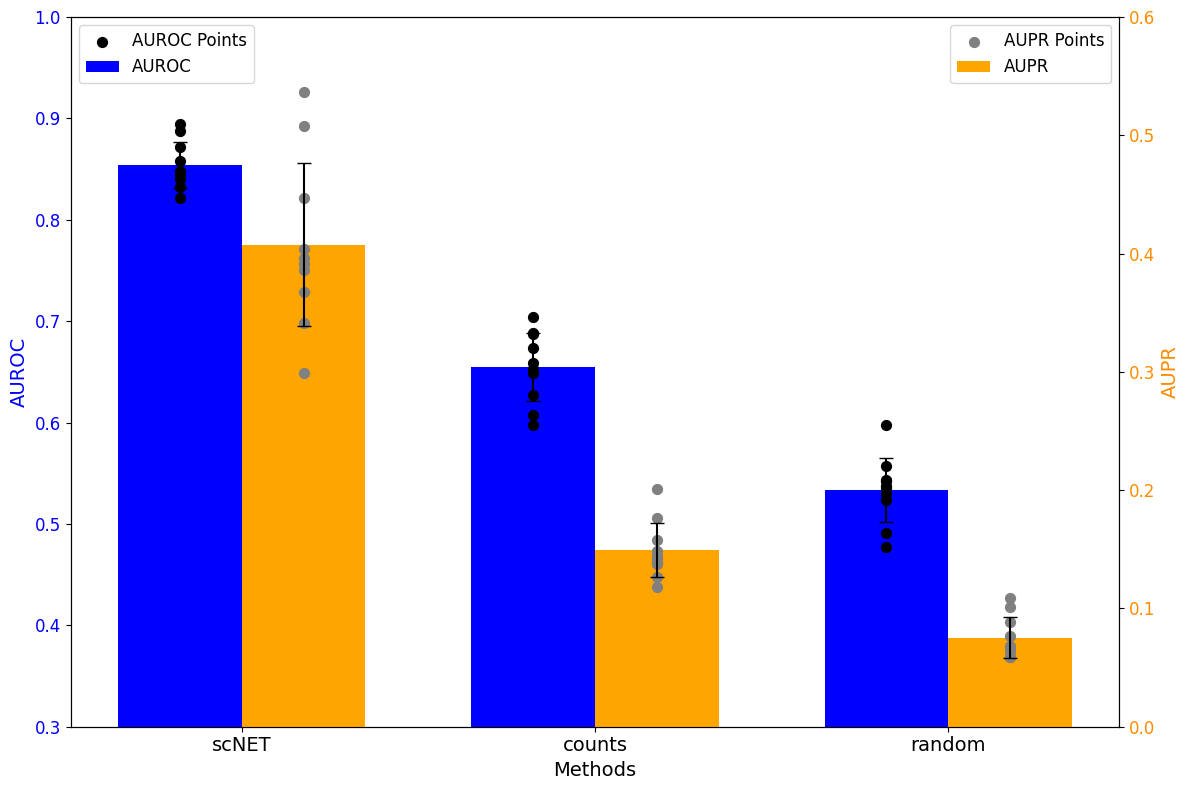

In [9]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['scNET', 'counts', 'random']

aurocs = [np.mean(method[0]) for method in results]
auprcs = [np.mean(method[1]) for method in results]
aurocs_err = [np.std(method[0]) for method in results]
auprcs_err = [np.std(method[1]) for method in results]

x = np.arange(len(methods))

fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35

ax1.bar(x - bar_width / 2, aurocs, yerr=aurocs_err, width=bar_width, label='AUROC', color='blue', capsize=5)
ax1.set_xlabel('Methods', fontsize=14)
ax1.set_ylabel('AUROC', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=14)
ax1.set_ylim([0.3, 1])

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, auprcs, yerr=auprcs_err, width=bar_width, label='AUPR', color='orange', capsize=5)
ax2.set_ylabel('AUPR', color='darkorange', fontsize=14)  # Use a darker orange color
ax2.tick_params(axis='y', labelcolor='darkorange', labelsize=12)
ax2.set_ylim([0, 0.6])


for i, (aurocs_data, auprcs_data) in enumerate(results):
    ax1.scatter([i - bar_width / 2] * len(aurocs_data), aurocs_data, color='black', s=50, label='AUROC Points' if i == 0 else "")
    ax2.scatter([i + bar_width / 2] * len(auprcs_data), auprcs_data, color='gray', s=50, label='AUPR Points' if i == 0 else "")

ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

### we can run the same process on GO Molecular Function Gene sets:

In [86]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("Tcells")
annot, row_embedding_df, node_features = create_annotation(node_features, embedded_genes, annotation_set=gp.get_library("GO_Molecular_Function_2023"), threshold=100)

In [87]:
Y = torch.tensor(annot.values).to(device)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = [predict_function(torch.tensor(df.values).float().to(device),Y, kf) for df in [row_embedding_df,node_features,node_features.sample(frac=1,replace=False)]]

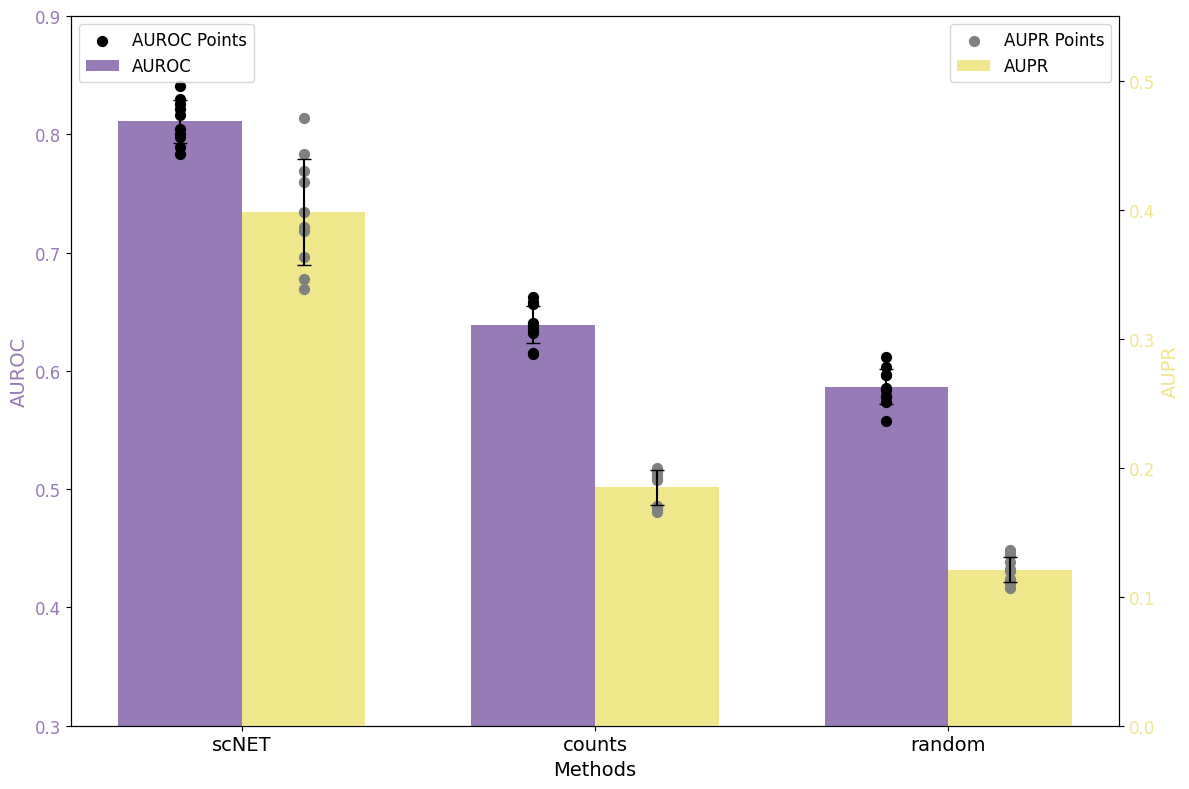

In [88]:
methods = ['scNET', 'counts', 'random']

aurocs = [np.mean(method[0]) for method in results]
auprcs = [np.mean(method[1]) for method in results]
aurocs_err = [np.std(method[0]) for method in results]
auprcs_err = [np.std(method[1]) for method in results]

x = np.arange(len(methods))

fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35

ax1.bar(x - bar_width / 2, aurocs, yerr=aurocs_err, width=bar_width, label='AUROC', color='#967BB6', capsize=5)
ax1.set_xlabel('Methods', fontsize=14)
ax1.set_ylabel('AUROC', color='#967BB6', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#967BB6', labelsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=14)
ax1.set_ylim([0.3, 0.9])

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, auprcs, yerr=auprcs_err, width=bar_width, label='AUPR', color='#F0E68C', capsize=5)
ax2.set_ylabel('AUPR', color='#F0E68C', fontsize=14)  # Use a darker orange color
ax2.tick_params(axis='y', labelcolor='#F0E68C', labelsize=12)
ax2.set_ylim([0, 0.55])


for i, (aurocs_data, auprcs_data) in enumerate(results):
    ax1.scatter([i - bar_width / 2] * len(aurocs_data), aurocs_data, color='black', s=50, label='AUROC Points' if i == 0 else "")
    ax2.scatter([i + bar_width / 2] * len(auprcs_data), auprcs_data, color='gray', s=50, label='AUPR Points' if i == 0 else "")

ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

###We can test the reconstructed gene expression using the Hallmark 2020 gene sets:

In [75]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("Tcells")
annot, out_features_df, node_features = create_annotation(node_features, out_features.T, annotation_set=gp.get_library("MSigDB_Hallmark_2020"), threshold=75)

In [78]:
Y = torch.tensor(annot.values).to(device)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = [predict_function(torch.tensor(df.values).float().to(device),Y, kf) for df in [out_features_df,node_features,node_features.sample(frac=1,replace=False)]]

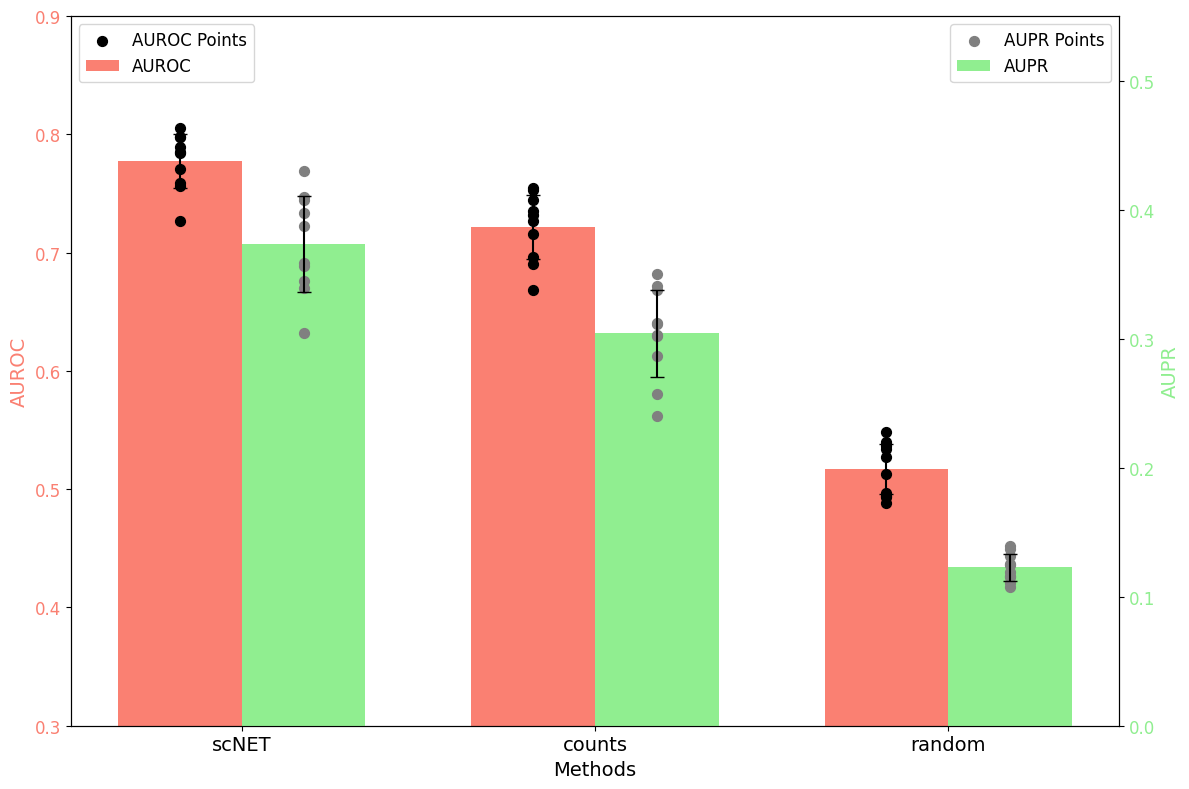

In [85]:
methods = ['scNET', 'counts', 'random']

aurocs = [np.mean(method[0]) for method in results]
auprcs = [np.mean(method[1]) for method in results]
aurocs_err = [np.std(method[0]) for method in results]
auprcs_err = [np.std(method[1]) for method in results]

x = np.arange(len(methods))

fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35

ax1.bar(x - bar_width / 2, aurocs, yerr=aurocs_err, width=bar_width, label='AUROC', color='#FA8072', capsize=5)
ax1.set_xlabel('Methods', fontsize=14)
ax1.set_ylabel('AUROC', color='#FA8072', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#FA8072', labelsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=14)
ax1.set_ylim([0.3, 0.9])

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, auprcs, yerr=auprcs_err, width=bar_width, label='AUPR', color='#90EE90', capsize=5)
ax2.set_ylabel('AUPR', color='#90EE90', fontsize=14)  # Use a darker orange color
ax2.tick_params(axis='y', labelcolor='#90EE90', labelsize=12)
ax2.set_ylim([0, 0.55])


for i, (aurocs_data, auprcs_data) in enumerate(results):
    ax1.scatter([i - bar_width / 2] * len(aurocs_data), aurocs_data, color='black', s=50, label='AUROC Points' if i == 0 else "")
    ax2.scatter([i + bar_width / 2] * len(auprcs_data), auprcs_data, color='gray', s=50, label='AUPR Points' if i == 0 else "")

ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()